In [1]:
# Import necessary libraries
import librosa
import numpy as np
import os
import pandas as pd
import concurrent.futures
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Convert MP3 files to WAV format
# Define paths
mp3_dir = r'C:/Users/yingx/data/MEMD_audio'
wav_dir = r'C:/Users/yingx/data/WaveFiles'

# Create output directory if it doesn't exist
os.makedirs(wav_dir, exist_ok=True)

# Process files from 2.mp3 to 2058.mp3
for i in range(2, 2059):
    mp3_path = os.path.join(mp3_dir, f'{i}.mp3')
    wav_path = os.path.join(wav_dir, f'{i}.wav')
    
    # Only process if the MP3 file exists
    if os.path.exists(mp3_path):
        try:
            # Load MP3 file with librosa (automatically converts to 22050 Hz mono)
            y, sr = librosa.load(mp3_path, sr=None)  # sr=None keeps original sample rate
            
            # Save as WAV file using soundfile
            sf.write(wav_path, y, sr)
            
            print(f'Successfully converted {i}.mp3 to {i}.wav')
        except Exception as e:
            print(f'Error processing {i}.mp3: {str(e)}')
    else:
        print(f'{i}.mp3 not found, skipping')

print('Conversion complete!')

In [ ]:
# Create feastures.csv from audio files in a specified directory    
def extract_features(wav_file):
    # Load the audio file
    y, sr = librosa.load(wav_file, sr=None)

    # Calculate features
    duration = librosa.get_duration(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
    chroma_feature = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)
    rms = np.mean(librosa.feature.rms(y=y))
    harmonicity = np.mean(librosa.effects.harmonic(y))

    return {
        'filename': os.path.basename(wav_file),
        'duration': duration,
        'tempo': tempo,
        'spectral_centroid': spectral_centroid,
        'zero_crossing_rate': zero_crossing_rate,
        'chroma_feature': chroma_feature.tolist(),
        'mfccs': mfccs.tolist(),
        'rms': rms,
        'harmonicity': harmonicity
    }

def save_features_to_csv(features, csv_file):
    # Create a DataFrame from the features
    df = pd.DataFrame(features)

    # Ensure the directory exists
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)

    # Save to CSV
    df.to_csv(csv_file, index=False)

def process_file(wav_file):
    if os.path.exists(wav_file):
        features = extract_features(wav_file)
        print(f"Processed: {wav_file}")
        return features
    else:
        print(f"File not found: {wav_file}")
        return None

def safe_extract(wav_file):
    try:
        if os.path.exists(wav_file):
            return extract_features(wav_file)
        else:
            print(f"File not found: {wav_file}")
            return None
    except Exception as e:
        print(f"Error processing {wav_file}: {e}")
        return None

if __name__ == "__main__":
    wav_dir = r'C:\Users\yingx\data\WaveFiles'
    output_csv = r'C:\Users\yingx\data\features.csv'
    # Start from 703.wav since previous files are already processed
    wav_files = [f'{wav_dir}\\{i}.wav' for i in range(703, 2059)]
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)

    batch_size = 100
    header_written = os.path.exists(output_csv)

    for batch_start in range(0, len(wav_files), batch_size):
        batch_files = wav_files[batch_start:batch_start + batch_size]
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(safe_extract, batch_files))
        features_batch = [res for res in results if res is not None]
        if features_batch:
            df = pd.DataFrame(features_batch)
            df.to_csv(output_csv, mode='a', header=not header_written, index=False)
            header_written = True
        print(f"Processed batch {batch_start + 703} to {batch_start + 703 + len(batch_files) - 1}")

    print(f"Feature extraction complete. Features saved to: {output_csv}")

File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\705.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\716.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\720.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\751.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\752.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\753.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\754.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\755.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\760.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\761.wav
File not found: C:\Users\yingx\OneDrive\Documents\GitHub\Capstone\data\WaveFiles\762.wav
File not found: C:\Us

In [6]:
# Load the features and annotations
features = pd.read_csv('C:\\Users\\yingx\\data\\features.csv')
annotations = pd.read_csv(r'C:\Users\yingx\data\annotations\annotations averaged per song\song_level\static_annotations_averaged_songs_1_2000.csv', skipinitialspace=True)

# Extract song_id from filename
features['song_id'] = features['filename'].str.extract('(\d+)').astype(int)

# Merge features with annotations
data = pd.merge(features, annotations, on='song_id')

# Convert string representations of lists to actual lists
data['chroma_feature'] = data['chroma_feature'].apply(eval)
data['mfccs'] = data['mfccs'].apply(eval)

# Create feature matrix
chroma_cols = pd.DataFrame(data['chroma_feature'].tolist(), columns=[f'chroma_{i}' for i in range(12)])
mfcc_cols = pd.DataFrame(data['mfccs'].tolist(), columns=[f'mfcc_{i}' for i in range(20)])

# Combine all features
X = pd.concat([
    data[['tempo', 'spectral_centroid', 'zero_crossing_rate', 'rms', 'harmonicity']],
    chroma_cols,
    mfcc_cols
], axis=1)

# Target variables
y = data[['valence_mean', 'arousal_mean']]
print(y)

      valence_mean  arousal_mean
0              3.1           3.0
1              3.5           3.3
2              5.7           5.5
3              4.4           5.3
4              5.8           6.4
...            ...           ...
1739           3.9           5.9
1740           5.3           3.9
1741           6.4           6.2
1742           4.6           5.4
1743           5.8           6.0

[1744 rows x 2 columns]


In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set size: 1395, Test set size: 349


In [11]:
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2)  # Two outputs: valence and arousal
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',  # Mean Squared Error for regression
                 metrics=['mae'])  # Mean Absolute Error
    
    return model

# Create model
input_shape = X_train_scaled.shape[1]
model = create_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4864      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 15,266
Trainable params: 15,266
Non-traina

In [12]:
# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
44/44 [==============================] - 1s 4ms/step - loss: 11.8354 - mae: 2.9306 - val_loss: 2.7482 - val_mae: 1.3222
Epoch 2/100
44/44 [==============================] - 0s 1ms/step - loss: 3.7832 - mae: 1.5250 - val_loss: 2.2309 - val_mae: 1.1952
Epoch 3/100
44/44 [==============================] - 0s 1ms/step - loss: 3.1236 - mae: 1.3580 - val_loss: 1.8778 - val_mae: 1.0949
Epoch 4/100
44/44 [==============================] - 0s 1ms/step - loss: 2.7978 - mae: 1.3001 - val_loss: 1.7241 - val_mae: 1.0486
Epoch 5/100
44/44 [==============================] - 0s 1ms/step - loss: 2.4891 - mae: 1.2450 - val_loss: 1.5788 - val_mae: 1.0104
Epoch 6/100
44/44 [==============================] - 0s 1ms/step - loss: 2.2277 - mae: 1.1829 - val_loss: 1.5704 - val_mae: 1.0042
Epoch 7/100
44/44 [==============================] - 0s 1ms/step - loss: 2.1604 - mae: 1.1447 - val_loss: 1.3584 - val_mae: 0.9369
Epoch 8/100
44/44 [==============================] - 0s 1ms/step - loss: 1.8908 - 

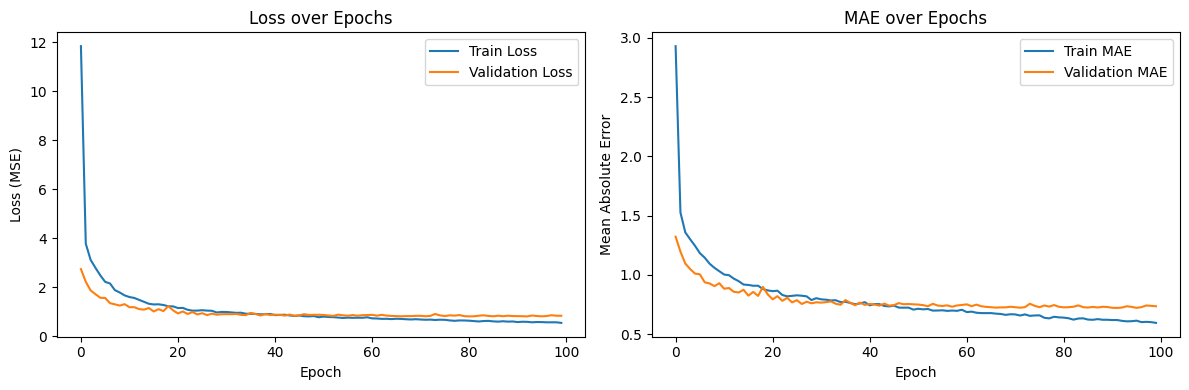

Test MSE: 0.8463
Test MAE: 0.7343
11/11 [==============================] - 0s 627us/step


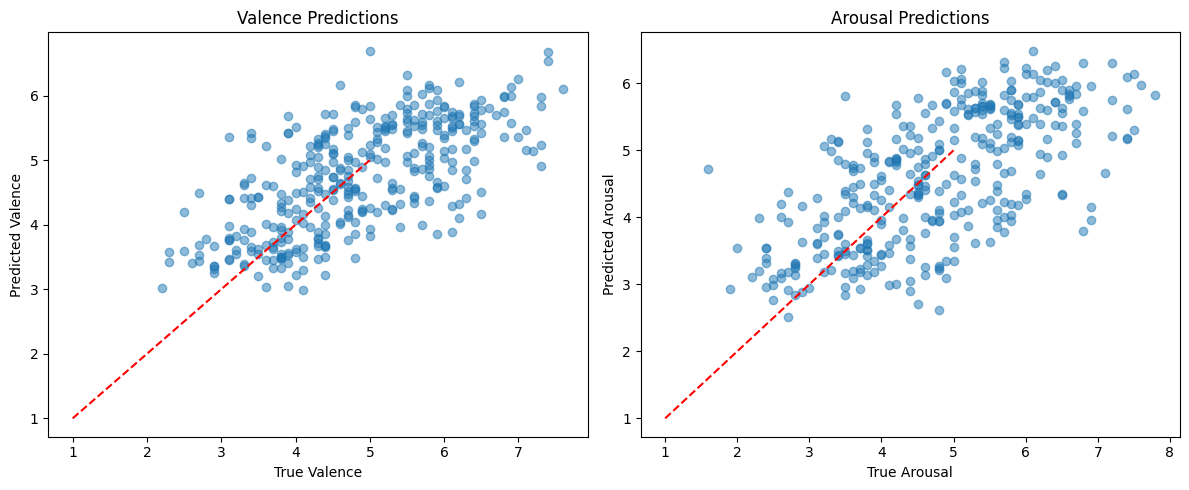

In [13]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test MSE: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Make predictions
y_pred = model.predict(X_test_scaled)

# Plot predictions vs true values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test['valence_mean'], y_pred[:, 0], alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')  # Perfect prediction line
plt.title('Valence Predictions')
plt.xlabel('True Valence')
plt.ylabel('Predicted Valence')

plt.subplot(1, 2, 2)
plt.scatter(y_test['arousal_mean'], y_pred[:, 1], alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')  # Perfect prediction line
plt.title('Arousal Predictions')
plt.xlabel('True Arousal')
plt.ylabel('Predicted Arousal')

plt.tight_layout()
plt.show()

In [14]:
# Save the model
model.save('emotion_predictor.h5')

# To load later:
# from tensorflow.keras.models import load_model
# loaded_model = load_model('emotion_predictor.h5')

In [ ]:
# Test the model with a new audio file
# Load your trained model
model = load_model('emotion_predictor.h5')  # Update path if needed

# Function to extract features from a single WAV file
def extract_features_for_prediction(wav_file):
    y, sr = librosa.load(wav_file, sr=None)
    
    features = {
        'tempo': librosa.beat.beat_track(y=y, sr=sr)[0],
        'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y=y)),
        'rms': np.mean(librosa.feature.rms(y=y)),
        'harmonicity': np.mean(librosa.effects.harmonic(y)),
        'chroma_feature': np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1),
        'mfccs': np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)
    }
    
    # Convert lists to DataFrame format
    chroma_df = pd.DataFrame([features['chroma_feature']], 
                            columns=[f'chroma_{i}' for i in range(12)])
    mfcc_df = pd.DataFrame([features['mfccs']], 
                          columns=[f'mfcc_{i}' for i in range(20)])
    
    # Create final feature vector
    X = pd.concat([
        pd.DataFrame([[features['tempo'], features['spectral_centroid'], 
                     features['zero_crossing_rate'], features['rms'], 
                     features['harmonicity']]], 
                  columns=['tempo', 'spectral_centroid', 'zero_crossing_rate', 'rms', 'harmonicity']),
        chroma_df,
        mfcc_df
    ], axis=1)
    
    return X

# Path to your new WAV file
wav_path = r'C:\Users\yingx\data\WaveFiles\2001.wav'

# Extract features
X_new = extract_features_for_prediction(wav_path)

# Load the scaler used during training (you need to save this during training)
# If you didn't save it, you'll need to refit it (not ideal)
scaler = StandardScaler()
# This assumes you have the original training data to fit the scaler
# Better to save the scaler during training using:
# from joblib import dump; dump(scaler, 'scaler.joblib')
# Then load here with: scaler = load('scaler.joblib')
scaler.fit(X_train)  # X_train from your training data
X_new_scaled = scaler.transform(X_new)

def interpret_emotion(valence, arousal):
    if valence > 0 and arousal > 0:
        return "happy"
    elif valence < 0 and arousal < 0:
        return "sad"
    elif arousal > 0 and valence < 0:
        return "angry"
    elif valence > 0 and arousal < 0:
        return "calm"
    else:
        return "neutral"

# Make prediction
prediction = model.predict(X_new_scaled)
valence_pred, arousal_pred = prediction[0]

# Interpret emotion
emotion = interpret_emotion(valence_pred, arousal_pred)

# Print results
print(f"Predicted Valence: {valence_pred:.2f}")
print(f"Predicted Arousal: {arousal_pred:.2f}")
print(f"\nThis song is: {emotion.upper()}")